# Notebook 39: Seismic imaging

How good are seismic data to image the subsurface? That is an important geological and geophysical question. This notebook addresses this question by producing a seismic image from an outcrop photo. The notebook was made by [Wiktor Weibull](mailto:wiktor.w.weibull@uis.no) at the University of Stavanger. 

## Python functions:

The functions [Stolt2Dmod and Stolt2Dmig](../functions/stolt_alg.py) by [Wiktor Weibull](mailto:wiktor.w.weibull@uis.no), implement the [Stolt algorithm](https://wiki.seg.org/wiki/Stolt_migration) to model and migrate zero-offset seismic data.

## Application:

The photo below by Marko Vrabec is from the external part of the Dinaric fold and thrust belt in the Istria peninsula, Adriatic coast, Slovenia ([Placer et al., 2010](https://www.geologija-revija.si/index.php/geologija/article/view/1205)). 

<img src="../figures/imbricate_thrusts.png" alt="imbricate_thrusts" width="650" style="display: block; margin: 0 auto"/><br><br>

Let's make a seismic image from this picture. First, we need to import the required libraries and specify some parameters:

In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# PLEASE SPECIFY THE FOLLOWING PARAMETERS
# Path to the image file
image_path = os.path.join("..", "figures", "imbricate_thrusts.png")
# Bin size of image in the horizontal in meters
DX = 2 
# Bin size of image in the vertical in meters
DZ = 2 
# P-wave velocity, in meters/second
V = 3000 
# Dip limitation at the receivers in degrees (90 degrees = no limitation)
AP = 90 
# Dominant frequency for the wavelet in Herz (Dominant wavelength = V/f0)
f0 = 50 

Then, we convert the image to grayscale, compute reflectivity from it, compute the wavelet, and display the image and reflectivity convolved with the wavelet: 

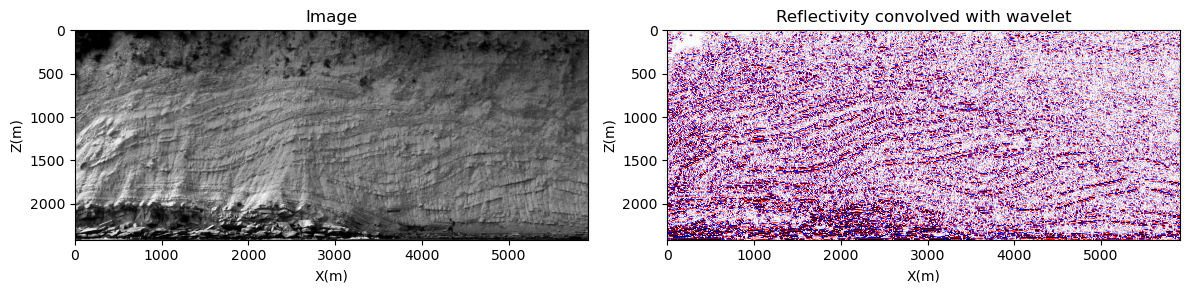

In [2]:
# Temporal sampling interval of the image
DT = 2*DZ/V

# Wavelet time delay (Ricker wavelet parameter)
t0=2/f0

# Read the image 
image = mpimg.imread(image_path)

# Convert the color image to grayscale
gray_image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])
gray_image = gray_image - np.min(gray_image) + 1.0

# Compute reflectivity
ref = np.zeros(gray_image.shape)
ref[0:-1, :] = (gray_image[1::,:] - gray_image[0:-1,:])/(gray_image[1::,:] + gray_image[0:-1,:])

# Compute wavelet 
t = np.linspace(0,ref.shape[0]-1, ref.shape[0])*DT
t0_i = int(t0/DT) 
arg = np.pi*np.pi*f0*f0*(t-t0)**2
wav = (1-2*arg)*np.exp(-arg)

#Bandlimit reflectivity using the wavelet
for i in range(0,ref.shape[1]):
    ref[:,i] = np.convolve(wav, ref[:,i])[t0_i:ref.shape[0]+t0_i]

# Display the image and reflectivity 
vm = np.percentile(ref,95)
fig,ax = plt.subplots(1,2, figsize=(12,4))
extent = (0, DX*(ref.shape[1]-1), DZ*(ref.shape[0]-1), 0)
ax[0].imshow(gray_image, cmap="gray", extent=extent)
ax[0].set_xlabel("X(m)")
ax[0].set_ylabel("Z(m)")
ax[0].set_title("Image")
ax[1].imshow(ref, vmin=-vm, vmax=vm, cmap="seismic", extent=extent)
ax[1].set_xlabel("X(m)")
ax[1].set_ylabel("Z(m)")
ax[1].set_title("Reflectivity convolved with wavelet")
fig.tight_layout()
plt.show()

Then, we model and migrate the seismic data using the Stolt algorithm:

In [3]:
# Seismic modelling and migration from reflectivity
# This adds the dip limitation due to wave propagation 
# and limited aperture effects

# import Wiktor's functions
sys.path.append(os.path.abspath(os.path.join("..", "functions")))
from stolt_alg import Stolt2Dmod, Stolt2Dmig

Mod = Stolt2Dmod(ref, V, DT, DX, AP)
Mig = Stolt2Dmig(Mod, V, DT, DX, AP)

Finally we plot the stacked and migrated seismic sections. Note that these sections are in time (two-way travel time, TWT, in seconds):

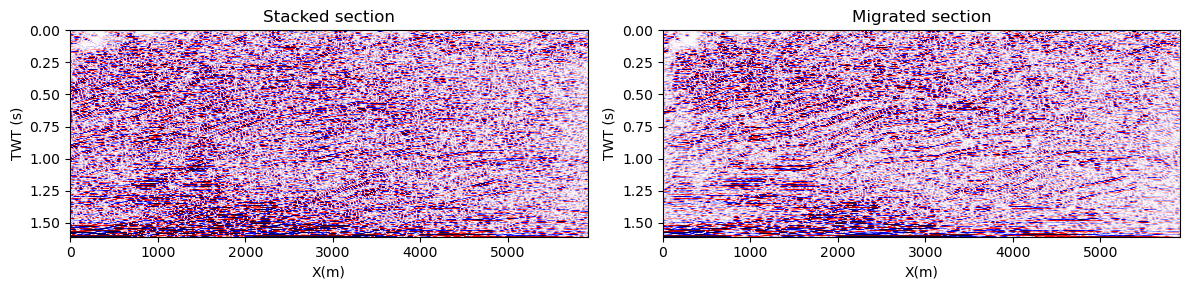

In [4]:
# Display the seismic modelled data and migrated data 
vm = np.percentile(Mod,95)
extent = (0, DX*(ref.shape[1]-1), DT*(ref.shape[0]-1), 0)
fig,ax = plt.subplots(1,2, figsize=(12,3))
ax[0].imshow(Mod, vmin=-vm, vmax=vm, cmap="seismic", extent=extent, aspect="auto")
ax[0].set_xlabel("X(m)")
ax[0].set_ylabel("TWT (s)")
ax[0].set_title("Stacked section")
ax[1].imshow(Mig, vmin=-vm, vmax=vm, cmap="seismic", extent=extent, aspect="auto")
ax[1].set_xlabel("X(m)")
ax[1].set_ylabel("TWT (s)")
ax[1].set_title("Migrated section")
fig.tight_layout()
plt.show()

Now it is possible to see how much of the structure is imaged by seismic. Try interpreting the migrated section, and then interpret the actual photo. This will illustrate how challenging seismic interpretation is.

It's easy to do another image. Just change the path in the first cell of the notebook, and run all cells.